In [1]:
import numpy as np
import scipy.signal as sig
import scipy.io
import os
import librosa
import sys

import matplotlib.pyplot as plt
plt.rc('text', usetex=True)
plt.rc('font', size=10)
plt.rc('font', family='serif')
cm = 2.54
# setting path
sys.path.append("../")
from Utils.dB import *
from HN_decomposition.Subspace.preprocessing import *
def RMS(x):
        return np.std(x)

## Loading the audio file

In [2]:
fileName = os.path.join('..', 'Data', 'Test', '69.wav')
x, sr_hz = librosa.load(fileName)
x = x[:2*sr_hz]



## Sub-band decomposition

(44100,)


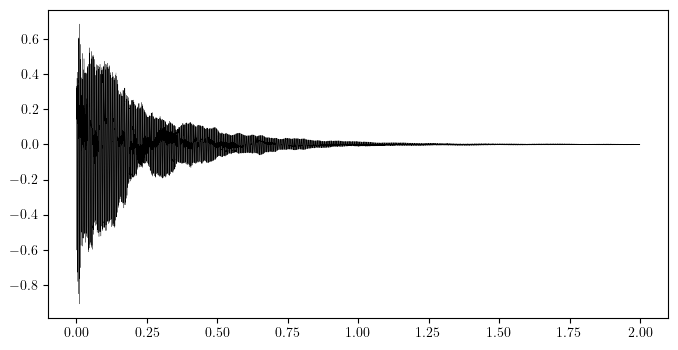

In [3]:

def filter_n_decimate(filterLength_smp : int, numBands : int, inputSignal : np.array):
    """
    args :
        - filterLength : [int]
            Digital filter length, in samples
        - numBands : [int]
            Number of frequency channels in which the signal is to be separated
        - inputSignal : [(1, N) np.array]
            Input signal 
    returns :
        - outputSignals : [(numBands, N) np.array]
            Output signal"""
    signalLength_smp = np.shape(inputSignal)[0] #Input signal length
    filteredSignal = np.zeros((signalLength_smp, numBands)) #initializing the output signal
    
    #h = scipy.signal.remez(numtaps = filterLength_smp, bands = [0, 1/(2*numBands), 1/(2*numBands), .5], fs = 1)

    for i in range(numBands):
        filteredSignal[:,i] = inputSignal

    filters = np.zeros((filterLength_smp, numBands))

    n = np.arange(filterLength_smp)
    base_filter = np.zeros(filterLength_smp)
    for i in range(filters):
        filters[i] = base_filter
    
    outputSignal = filteredSignal[::numBands]
    return outputSignal



print(np.shape(x))
plt.figure(figsize=(8,4))
plt.plot(np.arange(len(x))/sr_hz, x, 'k', linewidth = .2)
plt.show()

## Whitening the noise

In [4]:
rankFilter_bins = 51
rankFilter_rank = .3

n_fft = 512
hop_length = n_fft

In [5]:


x_stft = librosa.stft(x ,n_fft = n_fft, hop_length = hop_length, center=False)

xRankFiltered_stft = rankFilter_stft(x_stft, rankFilter_bins = rankFilter_bins, rankFilter_rank = rankFilter_rank)

t_list = librosa.frames_to_samples(np.arange(np.shape(x_stft)[1]), n_fft = n_fft, hop_length=hop_length)/sr_hz
f_list = librosa.fft_frequencies(sr = sr_hz, n_fft = n_fft)

print(f'sample rate : {sr_hz}')

#plt.pcolormesh(t_list, f_list, dB10(X), vmax = 40, vmin = -60, cmap = 'gray_r')
#plt.colorbar()
#plt.show()

sample rate : 22050


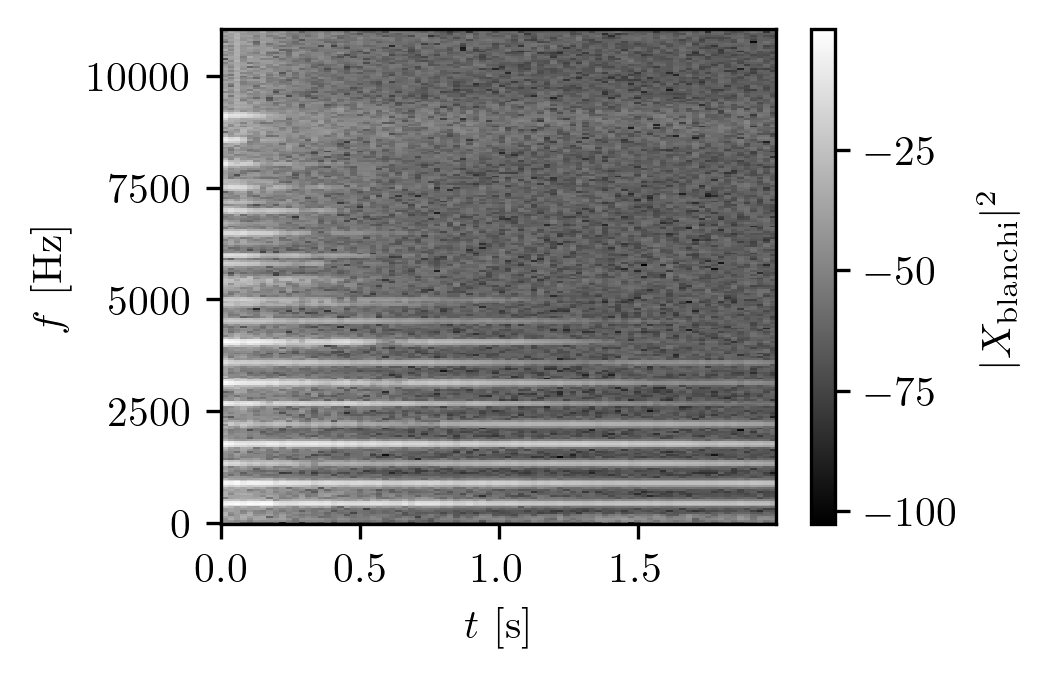

In [19]:
window_type = 'hann'
xWhitened, ARFilters = whiten_signal(
    x = x,
    n_fft = n_fft,
    hop_length = hop_length,
    rankFilter_bins = rankFilter_bins,
    rankFilter_rank = rankFilter_rank,
    ARFilter_length = 12,
    window_type=window_type)
xWhitened_stft = compute_stft_from_whitened(xWhitened, window_type=window_type)


cmap = 'gray'
dpi = 300
figsize = (9/cm, 6/cm)

plt.figure(figsize = figsize, dpi = dpi)
plt.pcolormesh(t_list, f_list, dB20(x_stft), cmap = cmap, rasterized=True)
plt.xlabel("$t$ [s]")
plt.ylabel("$f$ [Hz]")
plt.colorbar(label = '$|X|^2$')
plt.tight_layout()
plt.savefig(fname = os.path.join("..", "..", "PAM_overleaf", "Notes", "HR", "Figures", "input_stft.pdf"), dpi = dpi, bbox_inches = "tight", format = "pdf")
#plt.show()
plt.close()

plt.figure(figsize = figsize, dpi = dpi)
plt.pcolormesh(t_list, f_list, dB10(xRankFiltered_stft), cmap = cmap, rasterized=True)
plt.xlabel("$t$ [s]")
plt.ylabel("$f$ [Hz]")
plt.colorbar(label = '$|N|^2$')
plt.tight_layout()
plt.savefig(fname = os.path.join("..", "..", "PAM_overleaf", "Notes", "HR", "Figures", "noise_stft.pdf"), dpi = dpi, bbox_inches = "tight", format = "pdf")
#plt.show()
plt.close()


plt.figure(figsize = figsize, dpi = dpi)
plt.pcolormesh(t_list, f_list, dB20(xWhitened_stft), cmap = cmap, rasterized=True)
plt.xlabel("$t$ [s]")
plt.ylabel("$f$ [Hz]")
plt.colorbar(label = "$|X_{\mathrm{blanchi}}|^2$")
plt.tight_layout()
plt.savefig(fname = os.path.join("..", "..", "PAM_overleaf", "Notes", "HR", "Figures", "whitened_stft.pdf"), dpi = dpi, bbox_inches = "tight", format = "pdf")
plt.show()
plt.close()


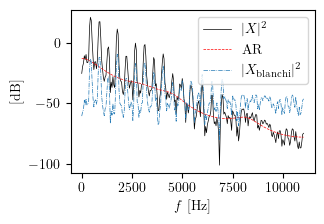

In [20]:
time_frame_display = 11

plt.figure(figsize = (8.5/cm, 6/cm))
#plt.figure(figsize = (15, 5))
plt.plot(f_list, dB20(x_stft[:,time_frame_display]), 'k', linewidth = .5, label = '$|X|^2$')
#plt.plot(f_list, dB10(xRankFiltered_stft[:,time_frame_display]), 'k--', linewidth = .5)
plt.plot(f_list, dB20(1/np.fft.rfft(ARFilters[:,11], n=n_fft)/300), 'r--', linewidth = .5, label = "AR")
plt.plot(f_list, dB20(xWhitened_stft[:,time_frame_display]), '-.', linewidth = .5, label = "$|X_{\mathrm{blanchi}}|^2$")
plt.legend(ncols = 1)
plt.xlabel("$f$ [Hz]")
plt.ylabel("[dB]")
plt.tight_layout()
plt.savefig(fname = os.path.join("..", "..", "PAM_overleaf", "Notes", "HR", "Figures", "blanchissement_spectre.pdf"), dpi = dpi, bbox_inches = "tight", format = "pdf")
plt.show()
plt.close()

## High-resolution Methods

### Méthode ESPRIT

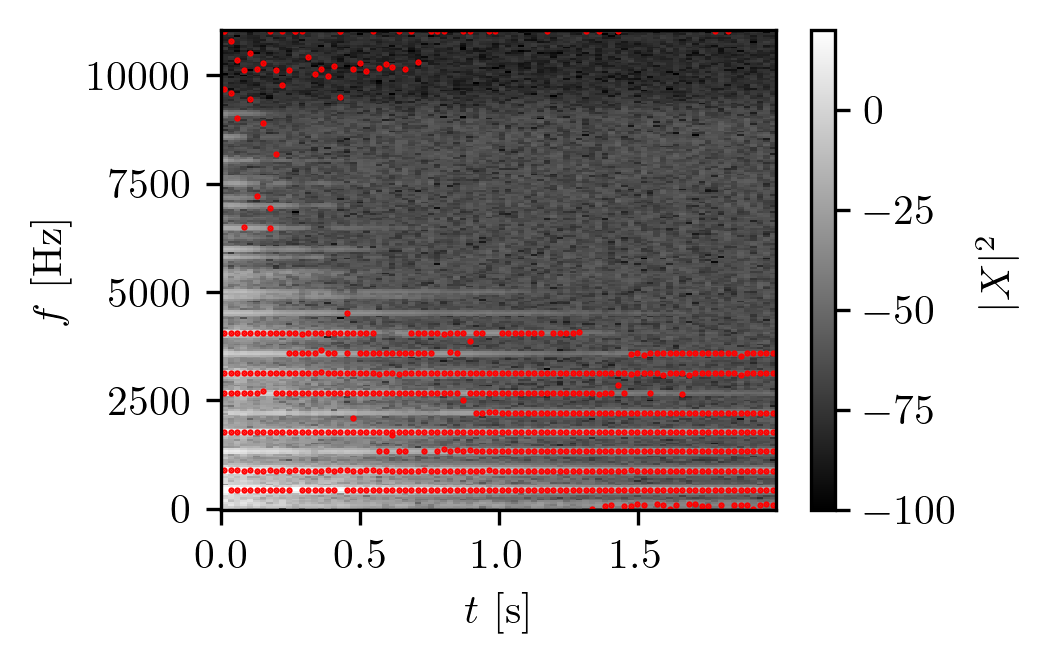

In [21]:
from HN_decomposition.Subspace.ESPRIT import *

num_poles = 16

plt.figure(figsize = figsize, dpi = dpi)
plt.pcolormesh(t_list, f_list, dB20(x_stft), cmap = cmap, vmax = 20, vmin = -100, rasterized=True)


for i in range(np.shape(xWhitened)[1]):
    poles, complexAmp, Lambda = ESPRIT(xWhitened[:,i], num_poles = num_poles)
    freqs = np.sort(sr_hz/(2*np.pi)*np.angle(poles))[num_poles//2:]
    plt.plot(np.ones(num_poles//2)*t_list[i], freqs, 'r.', markersize = 1)

plt.xlabel("$t$ [s]")
plt.ylabel("$f$ [Hz]")
plt.colorbar(label = '$|X|^2$')
plt.tight_layout()
#plt.savefig(fname = os.path.join("..", "..", "PAM_overleaf", "Notes", "HR", "Figures", "input_stft.pdf"), dpi = dpi, bbox_inches = "tight", format = "pdf")
plt.show()
plt.close()
